<a href="https://colab.research.google.com/github/jmhjimenez/AlexNet/blob/master/AlexNet_Gradient_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting Google Drive to Google Colab

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import os

In [0]:
%tensorflow_version 2.x
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import sys
import time
import pathlib
import glob
import IPython.display as display

from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import datasets

# **Parameters and Directories**

In [0]:
# DIRECTORY FORMAT
# Assuming dataset has been copied to Google Drive


'''
Dataset
    > train
        > class 1
            > image 1
            > image 2
            ...
        > class 2
            > ...
        > ...
    > test
        > ...
'''

In [0]:
# Set directories
gdrive_dir = "/content/drive/My Drive/Deep_Learning/CNN_models_test/AlexNet/"
train_dir = 'Datasets/intel-image-classification/train'
test_dir = "Datasets/intel-image-classification/test"


# change working directory to google drive project folder
os.chdir(gdrive_dir)

In [0]:
# Training Parameters
EPOCHS = 3
BATCH_SIZE = 128
image_height = 64
image_width = 64
input_shape = (64,64,3)
model_dir = "AlexNet.h5"
num_classes = 6
activation = 'relu'
weight_distribution = 'he_normal'

# Percentage of training data when splitting dataset into 
# training data and validation data
train_dataset_percent = 0.9

# **Data Preparation**

In [0]:
# pathlib.Path is used to avoid dependency error of OS used
train_dir = pathlib.Path(train_dir)


# The GLOB module finds all the pathnames matching a specified pattern
# Change file extension accordingly
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

# Use folder names inside train_dir as CLASS_NAMES 
CLASS_NAMES = np.array([class_name.name for class_name in list(train_dir.glob('*'))])
print(len(CLASS_NAMES))

11806
6


### **Display sample images from one class**

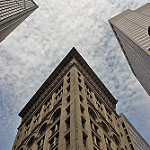

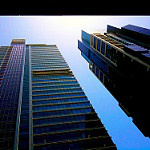

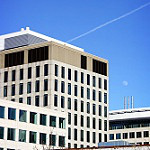

In [0]:
buildings = list(train_dir.glob('buildings/*'))

for image_path in buildings[:3]:
    display.display(Image.open(str(image_path)))

### **Convert file path to an (img, label) pair**

In [0]:
# Initialize dataset based on a list of image files
list_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))

# Retrieve label of image
def get_label(file_path):
    # convert the path to a list of path components
    # os.path.sep gets the separator of the system (e.g., "/") 
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory (subfolder name)
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    # may also use decode_image as a generic method that can infer image format to use
    img = tf.image.decode_jpeg(img, channels=3)     
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [image_width, image_height])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
# map function uses process_path method to all file paths
labeled_ds = list_ds.map(process_path, 
                         num_parallel_calls= tf.data.experimental.AUTOTUNE)

for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())



'''
-----------------------------------------------------------------
# check tf.data.TFRecordDataset for optimizing reading of files

Parsing TFRecord ﬁles
While listing all the image files and then iterating to open and parse them
 is astraightforward pipeline solution, it can be suboptimal. 
 Loading and parsing image filesone by one is resource-consuming. 
 Storing a large number of images together into a binaryfile would make 
 the read-from-disk operations (or streaming operations for remote files) 
 much more efficient.
 -----------------------------------------------------------------
'''

Image shape:  (64, 64, 3)
Label:  [False  True False False False False]


'\n-----------------------------------------------------------------\n# check tf.data.TFRecordDataset for optimizing reading of files\n\nParsing TFRecord ﬁles\nWhile listing all the image files and then iterating to open and parse them\n is astraightforward pipeline solution, it can be suboptimal. \n Loading and parsing image filesone by one is resource-consuming. \n Storing a large number of images together into a binaryfile would make \n the read-from-disk operations (or streaming operations for remote files) \n much more efficient.\n -----------------------------------------------------------------\n'

In [0]:
# Split dataset into training and validation dataset

train_dataset = labeled_ds.take(round(image_count * train_dataset_percent))
valid_dataset = labeled_ds.skip(round(image_count * train_dataset_percent))

# number of elements of training and validation data after splitting
num_train_elements = tf.data.experimental.cardinality(train_dataset).numpy()
num_valid_elements = tf.data.experimental.cardinality(valid_dataset).numpy()

print(num_train_elements)
print(num_valid_elements)

### **Shuffling, Batching, and Prefetching of Dataset**

In [0]:
# SHUFFLE_BUFFER_SIZE must be the size of training dataset

def prepare_for_training(ds, SHUFFLE_BUFFER_SIZE, BATCH_SIZE):
    
    '''
    can use cache method here for small datasets (<GB)
    '''
    
    ds = ds.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
    
    # Repeats this dataset until each original value is seen
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # This allows later elements to be prepared 
    # while the current element is being processed
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

In [0]:
prepared_train_dataset = prepare_for_training(train_dataset, 
                                     num_train_elements,
                                     BATCH_SIZE)

# **Building the Model**

In [0]:
# AlexNet model
def model_setup(input_shape, num_classes):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(96, kernel_size=(7,7), strides= 1,
                padding= 'valid', activation= 'relu',
                input_shape= input_shape, kernel_initializer= 'he_normal'))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                        padding= 'valid', data_format= None))
    
    model.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                        padding= 'valid', data_format= None)) 

    model.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    
    model.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    
    model.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                        padding= 'valid', data_format= None))

    model.add(Flatten())
    model.add(Dense(4096, activation= 'relu'))
    model.add(Dense(4096, activation= 'relu'))
    model.add(Dense(1000, activation= 'relu'))
    model.add(Dense(num_classes, activation= 'softmax'))
    
    
    return model

In [0]:
# Function for calculating gradients using Gradient Tape

def step(X, y):
    # keep track of our gradients
    with tf.GradientTape() as tape:
        # make a prediction using the model and then calculate the loss
        pred = model(X)
        loss = categorical_crossentropy(y, pred)
    
    # calculate the gradients using our tape and then update the model weights
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [0]:
# define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# create the model
model = model_setup(input_shape, num_classes)

# compute the number of batch updates per epoch
numUpdates = num_train_elements//BATCH_SIZE
print('no of iterations: ' + str(numUpdates))

# **Start of Training**

In [0]:
# loop over the number of epochs
for epoch in range(0, EPOCHS):
# for epoch in train_dataset.repeat(EPOCHS):

    # show the current epoch number
    epoch += 1
    print("[INFO] starting epoch {}/{}...".format(epoch, EPOCHS), end="")
    sys.stdout.flush()
    epochStart = time.time()
    
    # loop over the data in batch size increments
    for i in range(0, numUpdates):
        print(str(i) + '/' + str(numUpdates))
        image_batch, label_batch = next(iter(prepared_train_dataset))
        # take a step
        step(image_batch, label_batch)

    # show timing information for the epoch
    epochEnd = time.time()
    elapsed = (epochEnd - epochStart) / 60.0
    print("took {:.4} minutes".format(elapsed))

In [0]:
# in order to calculate accuracy using Keras' functions we first need to compile the model
model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=["acc"])

# **Sources**

In [0]:
'''
1. https://www.pyimagesearch.com/2020/03/23/using-tensorflow-and-gradienttape-to-train-a-keras-model/
2. https://www.tensorflow.org/tutorials/load_data/images#load_using_tfdata
3. 
'''